In [1]:
import json
import functools
import multiprocessing
from pathlib import Path

import numpy as np
import numpy.linalg
import pandas as pd
import scipy as sp
import scipy.optimize
from matplotlib import pyplot as plt

from helper import (
    get_station_data, 
    evaluate_markov_chain,
    get_train_test_time_ranges,
    calculate_n_ijh, calculate_p_ijh
)

In [2]:
province='AB'
#province='BC'
# province='MB'
#province='NB'
#province='NL'
#province='NS'
#province='NT'
#province='NU'
# province='ON'
#province='PE'
#province='QC'
#province='SK'
#province='YT'

# station_id_set = set(['6158355', '6158359'])
station_id_set = set(['3034479', '3034485'])

In [3]:
raw_data_base_dir = Path('raw-data')

In [4]:
df = get_station_data(
    raw_data_base_dir / province,
    station_id_set=station_id_set,
)

In [5]:
len(df)

311253

In [6]:
group = df.groupby('Climate ID')
display(group.count().rsub(group.size(), axis=0))

,Longitude (x),Latitude (y),Station Name,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
Climate ID,,,,,,,,,,
3034479,0,0,0,0,0,0,0,0,9405,1289
3034485,0,0,0,0,0,0,0,0,9609,915


In [7]:
valid_mask = (
    (~df['Wind Spd (km/h)'].isna())
)

In [8]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
0,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 15:00:00,2001,1,12,15:00,2.0,13.0
1,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 16:00:00,2001,1,12,16:00,1.0,11.0
2,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 17:00:00,2001,1,12,17:00,2.0,9.0
3,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 18:00:00,2001,1,12,18:00,2.0,9.0
4,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 19:00:00,2001,1,12,19:00,3.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
311248,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 21:00:00,2023,8,18,21:00,34.0,19.0
311249,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 22:00:00,2023,8,18,22:00,29.0,18.0
311250,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 22:00:00,2023,8,18,22:00,31.0,15.0
311251,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 23:00:00,2023,8,18,23:00,29.0,26.0


In [9]:
max_single_state = 5
state_bin_size = 10

df.loc[valid_mask, 'Wind Spd State'] = df.loc[valid_mask, 'Wind Spd (km/h)'] // state_bin_size
df.loc[~valid_mask, 'Wind Spd State'] = np.nan
df['Wind Spd State'].clip(upper=max_single_state, inplace=True)
df.loc[:,'Wind Spd State'] = df['Wind Spd State'].astype('Int8')

Climate ID
3034479    Axes(0.125,0.11;0.775x0.77)
3034485    Axes(0.125,0.11;0.775x0.77)
Name: Wind Spd (km/h), dtype: object

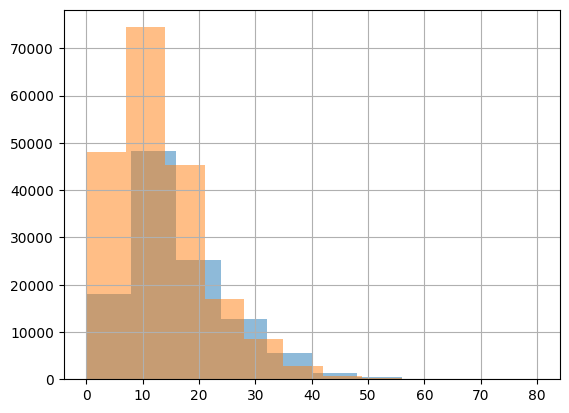

In [10]:
df.groupby('Climate ID')['Wind Spd (km/h)'].hist(alpha=0.5)

Climate ID
3034479    Axes(0.125,0.11;0.775x0.77)
3034485    Axes(0.125,0.11;0.775x0.77)
Name: Wind Spd State, dtype: object

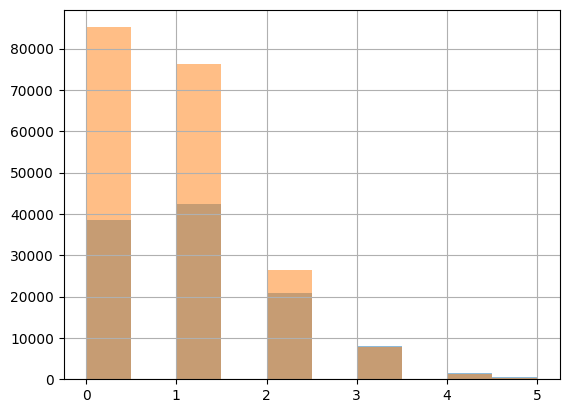

In [11]:
df.groupby('Climate ID')['Wind Spd State'].hist(alpha=0.5)

In [12]:
ts_dfs = []
for index, sub_df in df.groupby(by='Climate ID'):
    ts_df = sub_df[['Date/Time (LST)', 'Wind Spd State', ]]
    ts_df = (
        ts_df
        .set_index('Date/Time (LST)')
        .rename(
            columns={
                colname: f'{index} - {colname}'
                for colname in ts_df.columns
            },
        )
    )
    ts_dfs.append(ts_df)

ts_df = pd.concat(ts_dfs, ignore_index=False, axis='columns')
display(ts_df)

,3034479 - Wind Spd State,3034485 - Wind Spd State
Date/Time (LST),,
2001-01-12 15:00:00,<NA>,1
2001-01-12 16:00:00,<NA>,1
2001-01-12 17:00:00,<NA>,0
2001-01-12 18:00:00,<NA>,0
2001-01-12 19:00:00,<NA>,1
...,...,...
2023-08-18 19:00:00,4,2
2023-08-18 20:00:00,3,2
2023-08-18 21:00:00,3,1


In [13]:
ts_df['Wind Spd Multi-State'] = ts_df.iloc[:, 0] + max_single_state*ts_df.iloc[:, 1]

In [14]:
ts_df.iloc[:, 0].min()

0

In [15]:
ts_df.iloc[:, 0].max()

5

In [16]:
ts_df.iloc[:, 1].min()

0

In [17]:
ts_df.iloc[:, 1].max()

5

In [18]:
ts_df['Wind Spd Multi-State'].min()

0

In [19]:
ts_df['Wind Spd Multi-State'].max()

30

<Axes: >

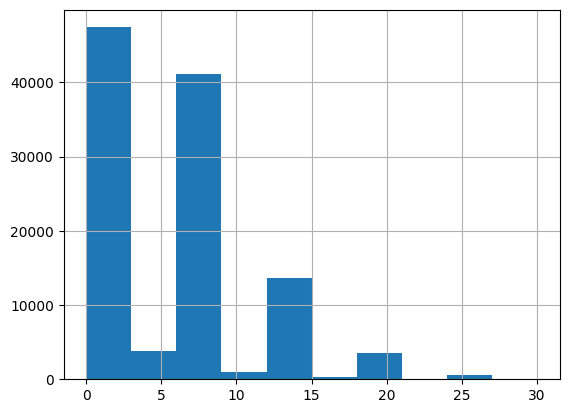

In [20]:
ts_df['Wind Spd Multi-State'].hist()

In [21]:
max_multi_state_val = (max_single_state+1)**2
display(max_multi_state_val)

36

In [22]:
ts_df['Wind Spd Multi-State'].max()

30

In [23]:
def objective_func(xx, p_ijh=None, weights=None):
    num_elements = xx.size
    side = int(np.sqrt(num_elements))
    matrix = xx.reshape(side,side)

    delta_matrices = [
        pij_h - matrix**hh
        for hh, pij_h  in enumerate(p_ijh, start=1)
    ]

    if weights is None:
        weights = np.array([1/len(delta_matrices) for _ in delta_matrices])

    delta_scores = np.array([
        np.linalg.norm(d_mat)
        for d_mat in delta_matrices
    ])
    score = np.sum(weights * delta_scores)

    return score

In [26]:
results = []
for idx,(train_range, test_range) in enumerate(get_train_test_time_ranges()):
    train_start, train_end = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)

    train_state_ts = ts_df.loc[train_mask, 'Wind Spd Multi-State']
    test_state_ts = ts_df.loc[~train_mask, 'Wind Spd Multi-State']

    n_ijh = calculate_n_ijh(train_state_ts)
    p_ijh = calculate_p_ijh(
        train_state_ts, n_ijh,
        min_state=0, 
        max_state=max_multi_state_val-1,
    )
    
    result = sp.optimize.differential_evolution(
        func=functools.partial(
            objective_func,
            p_ijh=p_ijh,
            # weights=None,
        ),
        bounds=[
            (-1, 1)
            for _ in np.ravel(p_ijh[0])
        ],
        x0=np.ravel(p_ijh[0]) if len(results) == 0 else results[-1].x,
        maxiter=100,
    )
    results.append(result)
    display(result)

    with open(f'markov-chain-with-magnitude-diff-evo-{idx}.json', 'w') as flink:
        json.dump(list(result.x), flink)

 message: Optimization terminated successfully.
 success: True
     fun: 1.0865671551717337
       x: [ 7.163e-01  1.323e-01 ...  0.000e+00  0.000e+00]
     nit: 42
    nfev: 863157

 message: Optimization terminated successfully.
 success: True
     fun: 1.9490048208126236
       x: [ 7.163e-01  1.323e-01 ...  0.000e+00  0.000e+00]
     nit: 38
    nfev: 775021

In [27]:
for (train_range, test_range), result in zip(get_train_test_time_ranges(),results):
    train_start, train_end = train_range
    test_start, test_range = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_range)

    train_state_ts = ts_df.loc[train_mask, 'Wind Spd Multi-State']
    test_state_ts = ts_df.loc[test_mask, 'Wind Spd Multi-State']

    forcast_series = evaluate_markov_chain(
        test_state_ts,
        transition_matrix_vec=result.x,
        vec_size=max_multi_state_val,
    )

    mean_error = (test_state_ts.iloc[:100] == forcast_series).mean()
    display(mean_error)

    display(result)
    print()


0.39

 message: Optimization terminated successfully.
 success: True
     fun: 1.0865671551717337
       x: [ 7.163e-01  1.323e-01 ...  0.000e+00  0.000e+00]
     nit: 42
    nfev: 863157

0.39

 message: Optimization terminated successfully.
 success: True
     fun: 1.9490048208126236
       x: [ 7.163e-01  1.323e-01 ...  0.000e+00  0.000e+00]
     nit: 38
    nfev: 775021

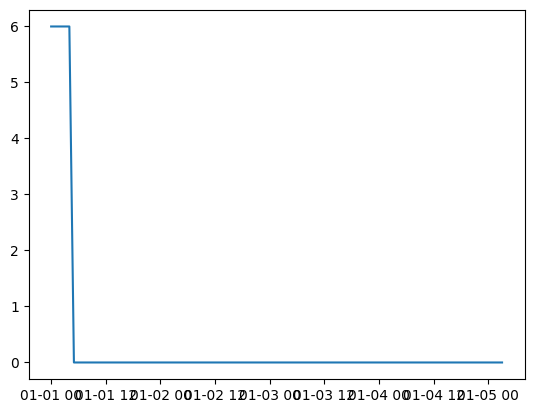

In [29]:
fig, ax = plt.subplots()

ax.plot(
    test_state_ts.index.to_numpy()[:100],
    forcast_series,
)
test_valid_mask = ~test_state_ts.isna()
# ax.plot(
#     test_state_ts[test_valid_mask].index,
#     test_state_ts[test_valid_mask].values,
# )

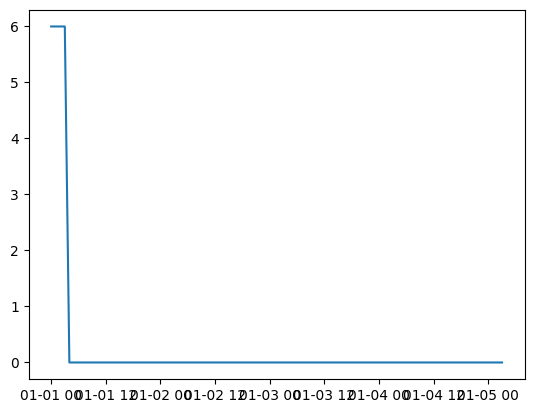

In [30]:

forcast_series_1 = evaluate_markov_chain(
    test_state_ts,
    transition_matrix_vec=np.ravel(p_ijh[0]),
    vec_size=max_multi_state_val,
)


fig, ax = plt.subplots()

ax.plot(
    test_state_ts.index.to_numpy()[:100],
    forcast_series_1,
)
test_valid_mask = ~test_state_ts.isna()
# ax.plot(
#     test_state_ts[test_valid_mask].index,
#     test_state_ts[test_valid_mask].values,
# )


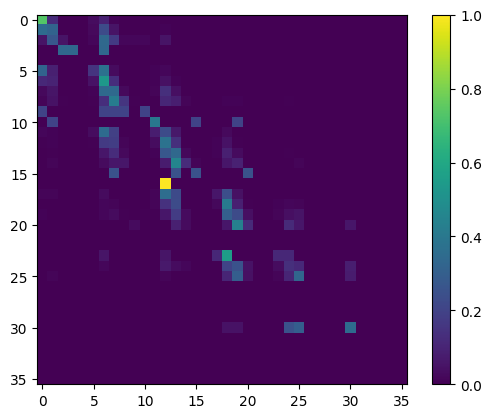

In [32]:
plt.imshow(p_ijh[0])
plt.colorbar()